In [69]:
%load_ext autoreload
%autoreload 2

import numpy as np

from src.channel_blocks import ChannelBlocks
from src.channel_simulation import ChannelSimulator
from src.split_step_fourier import SplitStepFourier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Channel Simulation
here starts the actual channel simulator code.

we will demonstrate the following block diagram


In [70]:
ssf = SplitStepFourier(
    alpha=0,
    b2=-20e-27,
    gamma=0.003,
    t0=125e-12,
    last_step=1.51e-3,
    dt=1e-12,
    h=10000
)
cs = ChannelSimulator(m_qam=16,
                      num_symbols=512,
                      normalization_factor=0.001,
                      channel_func=ssf,
                      verbose=False)
cb = ChannelBlocks(cs.verbose)

number of iterations in split step algo: 0


/Users/yarden/Desktop/thesis_stuff/Thesis-code/src/split_step_fourier.py:28: UserWarning: there are not enough (0) steps in split algo do at least one of the following: 
	1) reduce h
	2) enlarge t0
	3) enlarge last step

  "\t2) enlarge t0\n" \


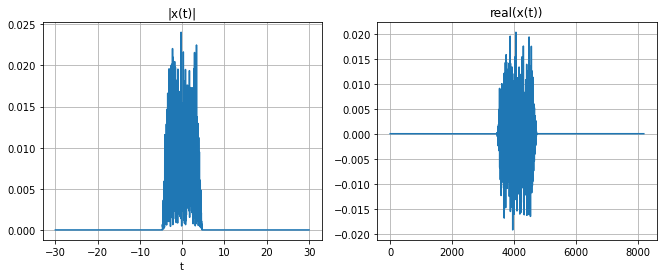

length of INFT(x) = 8192


In [71]:
cb.verbose = False
cs.x[0] = cb.generate_message(cs.length_of_msg, cs.sps)
cs.x[1], cs.modem = cb.modulate(cs.x[0], cs.m_qam)
cs.x[2] = cb.over_sample(cs.x[1], cs.over_sampling)
cs.x[3], cs.L_rrc, cs.h_rrc = cb.pulse_shape(cs.x[2], cs.roll_off, cs.over_sampling, cs.Ts)
cs.x[4] = cb.pre_equalize(cs.x[3], cs.normalization_factor)

cs.N_xi, cs.N_time, cs.tvec, cs.xivec, cs.BW = cb.gen_nft_params(cs.x[4], cs.Tmax)
cb.verbose = True
cs.x[5] = cb.inft(cs.x[4], cs.tvec, cs.xivec)

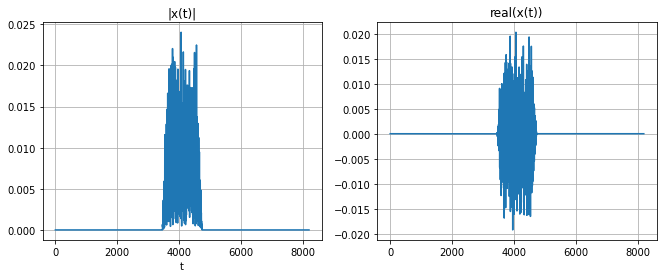

In [72]:
cs.x[6] = cb.channel(cs.x[5], cs.channel_func)

## 7) NFT

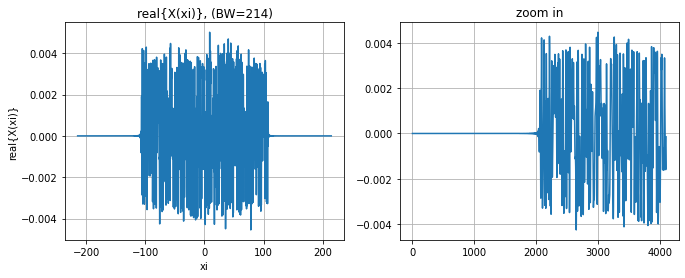

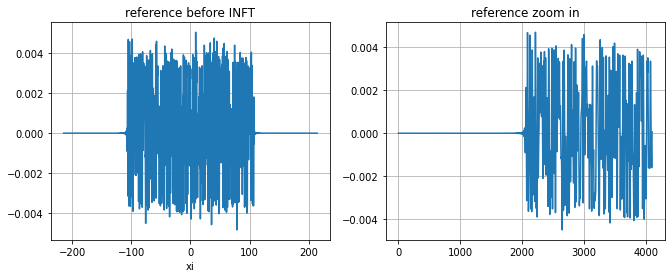

In [73]:
cs.x[7] = cb.nft(cs.x[5], cs.tvec, cs.xivec, cs.BW, cs.N_xi, cs.L_rrc, cs.x[4])

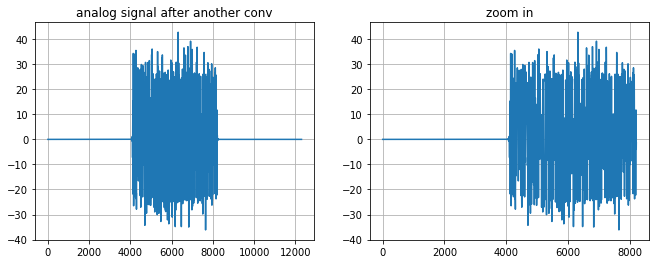

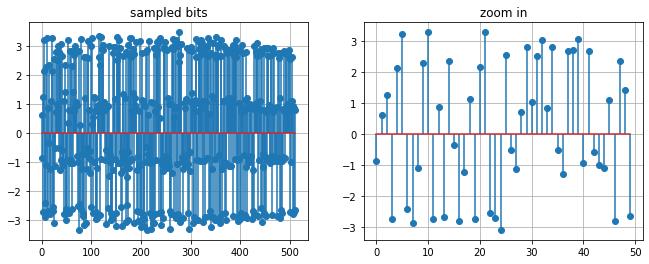

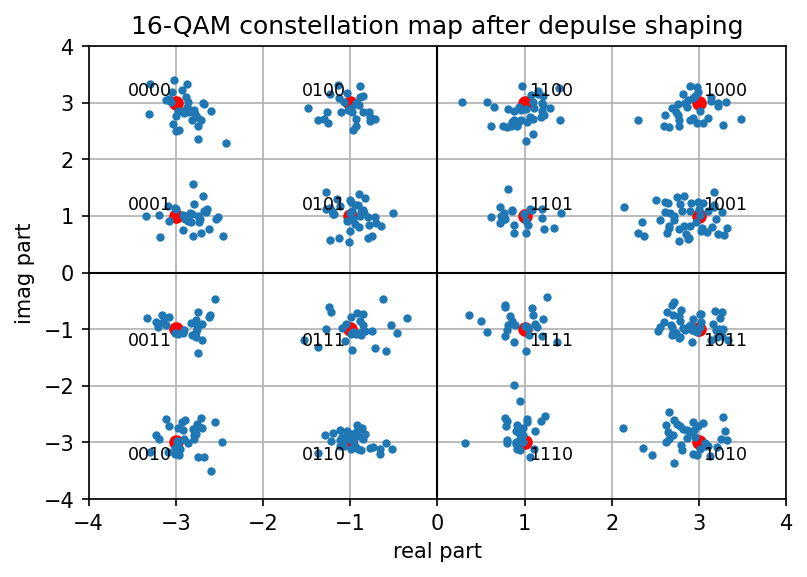

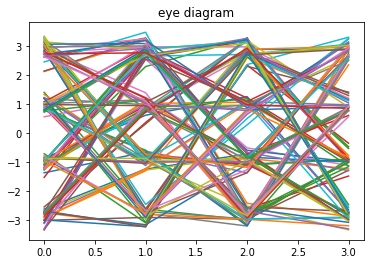


_______________________________________________
message after channel - len=2048
[[0 1 1 1]
 [1 1 0 0]
 [1 1 1 1]
 ...
 [1 1 0 1]
 [0 0 0 1]
 [1 1 1 0]]
ber = 0.00048828125 = 1/2048


In [74]:
cs.x[8] = cb.equalizer(cs.x[7], cs.normalization_factor)
cs.x[9] = cb.match_filter(cs.x[8], cs.h_rrc, cs.L_rrc, cs.over_sampling, cs.m_qam, cs.sps)
cs.x[10] = cb.demodulate(cs.x[9], cs.modem, cs.length_of_msg)
ber, num_errors = cb.calc_ber(cs.x[0], cs.x[10], cs.length_of_msg, cs.sps)